Because the residuals show a clear downward trend with distance, the linear model misses structure in the data, indicating that a curved relationship may fit better. To test whether the curved pattern in the residuals reflected a meaningful departure from linearity, I fit a simple quadratic regression model. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, calinski_harabasz_score
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture

plt.style.use("seaborn-v0_8")

## Global Linear Model

We begin with the classical Hubble-law regression:

\[
v = H_0 \, d_L + \epsilon
\]

This model estimates the Hubble constant as the slope.  
We evaluate performance using RMSE and examine residuals to assess model fit.


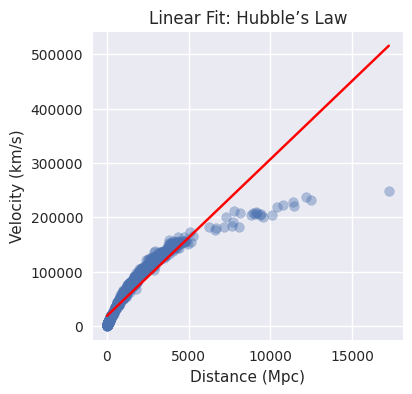

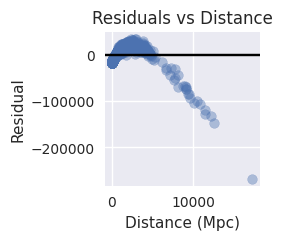

In [ ]:
df2 = pd.read_csv("/workspaces/final-project-karina-munoz/01 data/processed/clean_sn_data.csv")
x = df2[['d_L_Mpc']].values
y = df2['velocity_kms'].values

lin_model = LinearRegression()
lin_model.fit(x, y)

y_pred = lin_model.predict(x)

rmse_lin = np.sqrt(mean_squared_error(y, y_pred))
mae_lin = mean_absolute_error(y, y_pred)
r2_lin = lin_model.score(x, y)

rmse_lin, mae_lin, r2_lin

#linear fit plot
plt.figure(figsize=(4,4))
plt.scatter(x, y, alpha=0.4)
plt.plot(x, y_pred, color='red')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.title("Linear Fit: Hubble’s Law")
plt.savefig("Linearfit1.jpg")
plt.show()

#residual plot
residuals = y - y_pred
plt.figure(figsize=(4,4))
plt.scatter(x, residuals, alpha=0.4)
plt.axhline(0, color='black')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Residual")
plt.title("Residuals vs Distance")
plt.savefig("Residualfit1.jpg")
plt.show()

![](Linearfit1.jpg) ![](Residualfit1.jpg)

**Linear Fit Plot 1**:  
**Residual linear plot 1**:  

The global linear model fits the data well, with an RMSE of approximately **711 km/s**.  
This indicates that a single straight line captures most of the relationship between distance and recession velocity. However, the residuals show a slight downward pattern at the largest distances, raising the question of whether a nonlinear model is needed.

## Quadratic Model (Curvature Test)

To test whether curvature meaningfully improves the model, we fit a quadratic regression:

\[
v = \beta_1 d_L + \beta_2 d_L^2 + \epsilon
\]

If the quadratic term captures real structure in the data, the RMSE should decrease.


In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(x)

poly_model = LinearRegression()
poly_model.fit(x_poly, y)

y_poly_pred = poly_model.predict(x_poly)

rmse_poly = np.sqrt(mean_squared_error(y, y_poly_pred))
rmse_poly

np.float64(7604.113441774354)

The quadratic model **performs dramatically worse**, with an RMSE over **7600 km/s**.  
This indicates overfitting rather than improvement, and suggests that the slight curvature in the residuals is not modeling signal.

## Extension: Residual Behavior by Redshift

To investigate whether the residual structure at large distances reflects a physical effect or observational uncertainty,  
the dataset is split at **z = 0.05** into:

- **Low-z supernovae** (higher precision)
- **High-z supernovae** (higher uncertainty)

Separate linear regressions are fit to each subset to compare model stability.


In [ ]:
threshold = 0.05
low_z = df2[df2['zHD'] < threshold]
high_z = df2[df2['zHD'] >= threshold]

# Low-z model
lin_low = LinearRegression().fit(low_z[['d_L_Mpc']], low_z['velocity_kms'])
pred_low = lin_low.predict(low_z[['d_L_Mpc']])
rmse_low = np.sqrt(mean_squared_error(low_z['velocity_kms'], pred_low))

# High-z model
lin_high = LinearRegression().fit(high_z[['d_L_Mpc']], high_z['velocity_kms'])
pred_high = lin_high.predict(high_z[['d_L_Mpc']])
rmse_high = np.sqrt(mean_squared_error(high_z['velocity_kms'], pred_high))

rmse_low, rmse_high

lin_low.coef_[0], lin_high.coef_[0]

rmse_low = np.sqrt(mean_squared_error(low_z['velocity_kms'], pred_low))
rmse_high = np.sqrt(mean_squared_error(high_z['velocity_kms'], pred_high))
len(low_z), len(high_z), rmse_low, rmse_high



(645, 1056, np.float64(533.9045637891493), np.float64(16137.17428727836))

### Results

- **Low-z model**  
  - n = 645  
  - Slope ≈ 66.8 km/s/Mpc  
  - RMSE ≈ 534 km/s  
  - → Stable, consistent with global fit

- **High-z model**  
  - n = 1056  
  - Slope ≈ 23.2 km/s/Mpc  
  - RMSE ≈ 16,137 km/s  
  Unstable and dominated by measurement uncertainty

The large residuals at high distance are not a sign of nonlinear cosmic expansion.  
They arise from increasing measurement noise at higher redshift.  
Thus, the global linear Hubble model remains appropriate for this dataset.


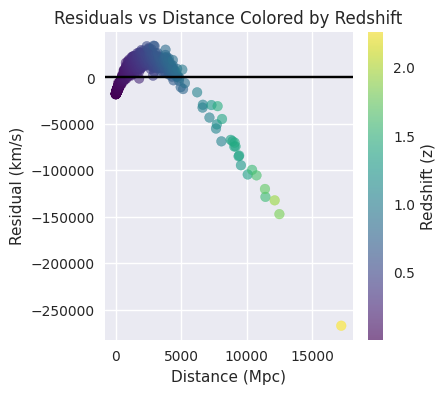

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(df2['d_L_Mpc'], residuals, c=df2['zHD'], cmap='viridis', alpha=0.6)
plt.colorbar(label="Redshift (z)")
plt.axhline(0, color='black')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Residual (km/s)")
plt.title("Residuals vs Distance Colored by Redshift")
plt.savefig("residuals_by_redshift.jpg")
plt.show()




To visualize uncertainty effects directly, the residual plot is colored by redshift.

Higher-z supernovae show much larger spread, confirming that observational noise—not curvature—is responsible for deviations from the linear model.


## Summary

- The global linear model fits the data well and gives a reasonable Hubble constant estimate.  
- A quadratic model performs far worse, indicating that curvature is not supported.  
- Subsetting the data by redshift shows that low-z supernovae follow the linear relation cleanly.  
- High-z supernovae produce increased residuals and unstable slope estimates due to measurement uncertainty.  
- Overall, the results strongly support a **linear Hubble law** within this dataset.

